In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

try:
    os.chdir(os.path.join(os.getcwd(), '../../catchgame/'))
except:
    print("already in directory")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is available")

cuda is available


## Experiment setup

In [2]:
import wandb 
from datetime import datetime
import pandas as pd

experiment_log = []

# function version
def save_experiment(outfolder="./runs"):
    run_name = "run-" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    os.makedirs(outfolder, exist_ok=True)
    os.makedirs(os.path.join(outfolder, run_name), exist_ok=True)
    keys = experiment_log[0].keys()
    for key in keys:
        np.save(os.path.join(outfolder, run_name, f"{key}.npy"), np.array([log.get(key, None) for log in experiment_log]))

    df = pd.DataFrame(experiment_log)
    df.to_csv(os.path.join(outfolder, run_name, "log.csv"), index=False)

    print(f"Experiment saved to {os.path.join(outfolder, run_name)}")

def init_experiment(config):
    wandb.init(
        project="rug-drl-catchgame",
        config=config,
    )

def terminate_experiment(save=True):
    wandb.finish()
    if save:
        save_experiment()

def log(data):
    experiment_log.append(data)
    print("; ".join([f"{k}: {v}" for k, v in data.items()]))
    wandb.log(data)



In [3]:
from modules.dqn.network import QNetworkConv
from world import CatchEnv

n_actions = 3
n_episodes = 1000
batch_size = 64

CATCH_ENV_NUM_STATES = 4
CATCH_ENV_WORLD_SIZE = (84, 84)
CATCH_ENV_POSSIBLE_ACTIONS = [0, 1, 2]

spatial_size = CATCH_ENV_WORLD_SIZE

dqn = QNetworkConv(
    in_channels=CATCH_ENV_NUM_STATES, 
    spatial_size=spatial_size, 
    output_size=len(CATCH_ENV_POSSIBLE_ACTIONS)
).to(device)
dqn_target = QNetworkConv(
    in_channels=CATCH_ENV_NUM_STATES,
    spatial_size=spatial_size,
    output_size=len(CATCH_ENV_POSSIBLE_ACTIONS)
).to(device)

In [4]:
env = CatchEnv()
env.reset_random()
next_state, reward, done = env.step(action=1)
next_state.shape, reward, done

((84, 84, 4), 0, False)

In [5]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize(spatial_size),
    lambda x: x.unsqueeze(0),
    lambda x: x.type(torch.float32),
])

transforms(next_state).shape

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 4, 84, 84])

In [6]:
optimizer = optim.Adam(dqn.parameters(), lr=1e-4)
criterion = nn.SmoothL1Loss()

num_episodes = 1000
epsilon = 0.8
gamma = 0.9
epsilon_decay = 0.99


In [7]:
import random
from collections import deque

# Define a replay buffer class to store experiences
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, done_flags = zip(*batch)
        return states, actions, rewards, next_states, done_flags

# Initialize the replay buffer
replay_buffer = ReplayBuffer(capacity=10000)

def evaulate(epsilon=0.0, num_episodes=10):
    rewards = []
    for episode in range(num_episodes):
        state = env.reset_random()
        state = transforms(state)
        done = False
        episode_reward = 0
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = random.choice(CATCH_ENV_POSSIBLE_ACTIONS)
            else:
                q_values = dqn(state.to(device))
                action = q_values.argmax().item()
            next_state, reward, done = env.step(action)
            next_state = transforms(next_state)
            episode_reward += reward
            state = next_state
        rewards.append(episode_reward)
    return np.mean(rewards)

def sample_epsilon_exponential_decay(min_epsilon=0.01, max_epsilon=0.9, t=0.0, decay_rate=0.5):
    I = max_epsilon
    E = min_epsilon
    s = 10 * decay_rate
    theta = (np.exp(-s*t) -1) / (1 - np.exp(-s)) + 1
    return (I - E) * theta + E

### Training

In [8]:

init_experiment(config={
    "num_episodes": num_episodes,
    "batch_size": batch_size,
    "gamma": gamma,
    "epsilon_decay": epsilon_decay,
    "spatial_size": spatial_size,
})

################ TRAINING ################

best_performance = evaulate(epsilon=0.0, num_episodes=10)
log({"episode": 0, "epsilon": 0.0})

for episode in tqdm(range(num_episodes)):
    # Initialize the environment and state
    state = env.reset_random()
    state = transforms(state)
    done = False
    
    done_i = 0

    while not done:
        # Choose an action using an epsilon-greedy policy
        if random.uniform(0, 1) < epsilon:
            action = random.choice(CATCH_ENV_POSSIBLE_ACTIONS)
        else:
            q_values = dqn(state.to(device))
            action = q_values.argmax().item()
        
        # Take the action and observe the next state and reward
        next_state, reward, done = env.step(action)
        next_state = transforms(next_state)
        
        # Add the experience to the replay buffer
        replay_buffer.add((state, action, reward, next_state, done))
        
        # Sample a batch of experiences from the replay buffer
        if len(replay_buffer.buffer) > batch_size:
            states, actions, rewards, next_states, done_flags = replay_buffer.sample(batch_size)
            # (batch, 4, 84, 84)
            # [(1, 4, 84, 84), ... ] -> (batch, 4, 84, 84)
            
            states = torch.cat(states).to(device)
            actions = torch.Tensor(actions).type(dtype=torch.int64).to(device)
            rewards = torch.Tensor(rewards).to(device)
            next_states = torch.cat(next_states).to(device)
            done_flags = torch.Tensor(done_flags).to(device)

            # Compute the target Q-values using the DDQN algorithm
            q_values = dqn(states)
            max_actions = q_values.argmax(dim=-1)
            
            with torch.no_grad():
                q_values_target = dqn_target(next_states)
            q_values_target = q_values_target.gather(1, max_actions.unsqueeze(-1)).squeeze(-1)
            q_values_target = rewards + gamma * q_values_target * (1 - done_flags)
            
            # Compute the current Q-values and the loss
            current_q_values = q_values.gather(1, torch.Tensor(actions).unsqueeze(-1)).squeeze(-1)
            loss = criterion(current_q_values, q_values_target.detach())
            
            # Update the DQN network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the target network
            if done_i % 10 == 0:
                dqn_target.load_state_dict(dqn.state_dict())
            done_i += 1
        
        # Update the state
        state = next_state

    # Evaluate the policy and save the results
    if episode % 10 == 0:
        mean_reward = evaulate(epsilon=0.0, num_episodes=10)
        epsilon = sample_epsilon_exponential_decay(t=mean_reward, decay_rate=0.01, max_epsilon=1, min_epsilon=0.1)
        if mean_reward >= best_performance:
            best_performance = mean_reward
            torch.save(dqn.state_dict(), "models/dqn_best.pt")
        log({"episode": episode, "mean_reward": mean_reward, "epsilon": epsilon})

################ TRAINING END ################  

terminate_experiment()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: massaf (rug-ai-group). Use `wandb login --relogin` to force relogin


episode: 0; epsilon: 0.0


  0%|          | 1/1000 [00:00<02:22,  6.99it/s]

episode: 0; mean_reward: 0.0; epsilon: 1.0


  1%|          | 12/1000 [00:01<01:43,  9.51it/s]

episode: 10; mean_reward: 0.4; epsilon: 0.6291661697846308


  2%|▏         | 22/1000 [00:02<02:06,  7.71it/s]

episode: 20; mean_reward: 0.4; epsilon: 0.6291661697846308


  3%|▎         | 32/1000 [00:03<02:35,  6.22it/s]

episode: 30; mean_reward: 0.2; epsilon: 0.8127289775444044


  4%|▍         | 42/1000 [00:05<03:08,  5.09it/s]

episode: 40; mean_reward: 0.2; epsilon: 0.8127289775444044


  5%|▌         | 52/1000 [00:06<02:25,  6.53it/s]

episode: 50; mean_reward: 0.2; epsilon: 0.8127289775444044


  6%|▌         | 62/1000 [00:08<02:09,  7.24it/s]

episode: 60; mean_reward: 0.4; epsilon: 0.6291661697846308


  7%|▋         | 72/1000 [00:09<02:18,  6.71it/s]

episode: 70; mean_reward: 0.3; epsilon: 0.7204886704693053


  8%|▊         | 82/1000 [00:10<02:21,  6.48it/s]

episode: 80; mean_reward: 0.6; epsilon: 0.449238149150038


  9%|▉         | 92/1000 [00:11<02:17,  6.61it/s]

episode: 90; mean_reward: 0.2; epsilon: 0.8127289775444044


 10%|█         | 102/1000 [00:13<02:24,  6.21it/s]

episode: 100; mean_reward: 0.4; epsilon: 0.6291661697846308


 11%|█         | 112/1000 [00:14<02:16,  6.52it/s]

episode: 110; mean_reward: 0.4; epsilon: 0.6291661697846308


 12%|█▏        | 122/1000 [00:16<02:27,  5.97it/s]

episode: 120; mean_reward: 0.6; epsilon: 0.449238149150038


 13%|█▎        | 132/1000 [00:17<02:15,  6.40it/s]

episode: 130; mean_reward: 0.2; epsilon: 0.8127289775444044


 14%|█▍        | 142/1000 [00:18<02:14,  6.37it/s]

episode: 140; mean_reward: 0.4; epsilon: 0.6291661697846308


 15%|█▌        | 152/1000 [00:20<02:11,  6.45it/s]

episode: 150; mean_reward: 0.4; epsilon: 0.6291661697846308


 16%|█▌        | 162/1000 [00:21<02:01,  6.88it/s]

episode: 160; mean_reward: 0.4; epsilon: 0.6291661697846308


 17%|█▋        | 172/1000 [00:22<01:56,  7.09it/s]

episode: 170; mean_reward: 0.2; epsilon: 0.8127289775444044


 18%|█▊        | 182/1000 [00:24<02:08,  6.36it/s]

episode: 180; mean_reward: 0.2; epsilon: 0.8127289775444044


 19%|█▉        | 192/1000 [00:25<02:01,  6.68it/s]

episode: 190; mean_reward: 0.2; epsilon: 0.8127289775444044


 20%|██        | 202/1000 [00:26<01:48,  7.36it/s]

episode: 200; mean_reward: 0.4; epsilon: 0.6291661697846308


 21%|██        | 212/1000 [00:28<02:03,  6.36it/s]

episode: 210; mean_reward: 0.5; epsilon: 0.5387523431642111


 22%|██▏       | 222/1000 [00:29<01:57,  6.65it/s]

episode: 220; mean_reward: 0.7; epsilon: 0.3606146362481154


 23%|██▎       | 232/1000 [00:30<01:53,  6.75it/s]

episode: 230; mean_reward: 0.4; epsilon: 0.6291661697846308


 24%|██▍       | 242/1000 [00:32<01:49,  6.90it/s]

episode: 240; mean_reward: 0.5; epsilon: 0.5387523431642111


 25%|██▌       | 252/1000 [00:33<01:50,  6.76it/s]

episode: 250; mean_reward: 0.4; epsilon: 0.6291661697846308


 26%|██▌       | 262/1000 [00:34<01:45,  7.01it/s]

episode: 260; mean_reward: 0.2; epsilon: 0.8127289775444044


 27%|██▋       | 272/1000 [00:35<01:44,  6.97it/s]

episode: 270; mean_reward: 0.5; epsilon: 0.5387523431642111


 28%|██▊       | 282/1000 [00:37<01:43,  6.95it/s]

episode: 280; mean_reward: 0.5; epsilon: 0.5387523431642111


 29%|██▉       | 292/1000 [00:38<01:44,  6.75it/s]

episode: 290; mean_reward: 0.3; epsilon: 0.7204886704693053


 30%|███       | 302/1000 [00:39<01:46,  6.58it/s]

episode: 300; mean_reward: 0.2; epsilon: 0.8127289775444044


 31%|███       | 312/1000 [00:41<01:44,  6.59it/s]

episode: 310; mean_reward: 0.6; epsilon: 0.449238149150038


 32%|███▏      | 322/1000 [00:42<01:40,  6.77it/s]

episode: 320; mean_reward: 0.3; epsilon: 0.7204886704693053


 33%|███▎      | 332/1000 [00:43<01:37,  6.87it/s]

episode: 330; mean_reward: 0.6; epsilon: 0.449238149150038


 34%|███▍      | 342/1000 [00:44<01:36,  6.85it/s]

episode: 340; mean_reward: 0.3; epsilon: 0.7204886704693053


 35%|███▌      | 352/1000 [00:46<01:28,  7.33it/s]

episode: 350; mean_reward: 0.4; epsilon: 0.6291661697846308


 36%|███▌      | 362/1000 [00:47<01:35,  6.71it/s]

episode: 360; mean_reward: 0.7; epsilon: 0.3606146362481154


 37%|███▋      | 372/1000 [00:48<01:31,  6.84it/s]

episode: 370; mean_reward: 0.4; epsilon: 0.6291661697846308


 38%|███▊      | 382/1000 [00:49<01:31,  6.78it/s]

episode: 380; mean_reward: 0.4; epsilon: 0.6291661697846308


 39%|███▉      | 392/1000 [00:51<01:31,  6.67it/s]

episode: 390; mean_reward: 0.3; epsilon: 0.7204886704693053


 40%|████      | 402/1000 [00:52<01:25,  6.97it/s]

episode: 400; mean_reward: 0.5; epsilon: 0.5387523431642111


 41%|████      | 412/1000 [00:53<01:23,  7.08it/s]

episode: 410; mean_reward: 0.4; epsilon: 0.6291661697846308


 42%|████▏     | 422/1000 [00:55<01:22,  7.05it/s]

episode: 420; mean_reward: 0.4; epsilon: 0.6291661697846308


 43%|████▎     | 432/1000 [00:56<01:23,  6.84it/s]

episode: 430; mean_reward: 0.5; epsilon: 0.5387523431642111


 44%|████▍     | 442/1000 [00:57<01:18,  7.11it/s]

episode: 440; mean_reward: 0.7; epsilon: 0.3606146362481154


 45%|████▌     | 452/1000 [00:59<01:22,  6.64it/s]

episode: 450; mean_reward: 0.2; epsilon: 0.8127289775444044


 46%|████▌     | 462/1000 [01:00<01:15,  7.14it/s]

episode: 460; mean_reward: 0.6; epsilon: 0.449238149150038


 47%|████▋     | 472/1000 [01:01<01:16,  6.86it/s]

episode: 470; mean_reward: 0.4; epsilon: 0.6291661697846308


 48%|████▊     | 482/1000 [01:02<01:16,  6.78it/s]

episode: 480; mean_reward: 0.5; epsilon: 0.5387523431642111


 49%|████▉     | 492/1000 [01:04<01:15,  6.71it/s]

episode: 490; mean_reward: 0.3; epsilon: 0.7204886704693053


 50%|█████     | 501/1000 [01:05<01:14,  6.70it/s]

episode: 500; mean_reward: 0.2; epsilon: 0.8127289775444044


 51%|█████     | 512/1000 [01:06<01:07,  7.25it/s]

episode: 510; mean_reward: 0.6; epsilon: 0.449238149150038


 52%|█████▏    | 522/1000 [01:07<01:09,  6.90it/s]

episode: 520; mean_reward: 0.6; epsilon: 0.449238149150038


 53%|█████▎    | 532/1000 [01:09<01:06,  7.00it/s]

episode: 530; mean_reward: 0.7; epsilon: 0.3606146362481154


 54%|█████▍    | 542/1000 [01:10<01:04,  7.16it/s]

episode: 540; mean_reward: 0.7; epsilon: 0.3606146362481154


 55%|█████▌    | 552/1000 [01:11<01:03,  7.05it/s]

episode: 550; mean_reward: 0.9; epsilon: 0.18600429226305015


 56%|█████▌    | 562/1000 [01:13<01:04,  6.75it/s]

episode: 560; mean_reward: 0.6; epsilon: 0.449238149150038


 57%|█████▋    | 572/1000 [01:14<01:07,  6.35it/s]

episode: 570; mean_reward: 0.4; epsilon: 0.6291661697846308


 58%|█████▊    | 582/1000 [01:15<01:03,  6.57it/s]

episode: 580; mean_reward: 0.4; epsilon: 0.6291661697846308


 59%|█████▉    | 592/1000 [01:17<01:00,  6.71it/s]

episode: 590; mean_reward: 0.5; epsilon: 0.5387523431642111


 60%|██████    | 602/1000 [01:18<00:58,  6.85it/s]

episode: 600; mean_reward: 0.7; epsilon: 0.3606146362481154


 61%|██████    | 612/1000 [01:19<01:03,  6.09it/s]

episode: 610; mean_reward: 0.6; epsilon: 0.449238149150038


 62%|██████▏   | 622/1000 [01:21<00:55,  6.80it/s]

episode: 620; mean_reward: 0.5; epsilon: 0.5387523431642111


 63%|██████▎   | 632/1000 [01:22<00:54,  6.70it/s]

episode: 630; mean_reward: 0.3; epsilon: 0.7204886704693053


 64%|██████▍   | 642/1000 [01:23<00:56,  6.38it/s]

episode: 640; mean_reward: 0.7; epsilon: 0.3606146362481154


 65%|██████▌   | 652/1000 [01:25<00:53,  6.51it/s]

episode: 650; mean_reward: 0.7; epsilon: 0.3606146362481154


 66%|██████▌   | 662/1000 [01:26<00:56,  5.99it/s]

episode: 660; mean_reward: 0.8; epsilon: 0.2728729420332988


 67%|██████▋   | 672/1000 [01:28<00:52,  6.22it/s]

episode: 670; mean_reward: 0.2; epsilon: 0.8127289775444044


 68%|██████▊   | 682/1000 [01:29<00:46,  6.88it/s]

episode: 680; mean_reward: 0.5; epsilon: 0.5387523431642111


 69%|██████▉   | 692/1000 [01:30<00:47,  6.43it/s]

episode: 690; mean_reward: 0.4; epsilon: 0.6291661697846308


 70%|███████   | 702/1000 [01:32<00:42,  7.03it/s]

episode: 700; mean_reward: 0.8; epsilon: 0.2728729420332988


 71%|███████   | 712/1000 [01:33<00:44,  6.43it/s]

episode: 710; mean_reward: 0.7; epsilon: 0.3606146362481154


 72%|███████▏  | 722/1000 [01:34<00:43,  6.34it/s]

episode: 720; mean_reward: 0.8; epsilon: 0.2728729420332988


 73%|███████▎  | 732/1000 [01:36<00:42,  6.29it/s]

episode: 730; mean_reward: 0.6; epsilon: 0.449238149150038


 74%|███████▍  | 742/1000 [01:37<00:39,  6.57it/s]

episode: 740; mean_reward: 0.7; epsilon: 0.3606146362481154


 75%|███████▌  | 752/1000 [01:39<00:39,  6.24it/s]

episode: 750; mean_reward: 0.7; epsilon: 0.3606146362481154


 76%|███████▌  | 762/1000 [01:40<00:44,  5.35it/s]

episode: 760; mean_reward: 0.9; epsilon: 0.18600429226305015


 77%|███████▋  | 772/1000 [01:42<00:36,  6.18it/s]

episode: 770; mean_reward: 0.6; epsilon: 0.449238149150038


 78%|███████▊  | 782/1000 [01:43<00:37,  5.81it/s]

episode: 780; mean_reward: 0.9; epsilon: 0.18600429226305015


 79%|███████▉  | 792/1000 [01:45<00:31,  6.56it/s]

episode: 790; mean_reward: 1.0; epsilon: 0.1


 80%|████████  | 802/1000 [01:46<00:28,  6.96it/s]

episode: 800; mean_reward: 0.8; epsilon: 0.2728729420332988


 81%|████████  | 812/1000 [01:47<00:28,  6.69it/s]

episode: 810; mean_reward: 0.6; epsilon: 0.449238149150038


 82%|████████▏ | 822/1000 [01:49<00:27,  6.57it/s]

episode: 820; mean_reward: 0.7; epsilon: 0.3606146362481154


 83%|████████▎ | 832/1000 [01:50<00:26,  6.43it/s]

episode: 830; mean_reward: 0.8; epsilon: 0.2728729420332988


 84%|████████▍ | 842/1000 [01:51<00:23,  6.75it/s]

episode: 840; mean_reward: 0.9; epsilon: 0.18600429226305015


 85%|████████▌ | 852/1000 [01:53<00:21,  6.93it/s]

episode: 850; mean_reward: 0.8; epsilon: 0.2728729420332988


 86%|████████▌ | 862/1000 [01:54<00:20,  6.65it/s]

episode: 860; mean_reward: 0.9; epsilon: 0.18600429226305015


 87%|████████▋ | 872/1000 [01:55<00:18,  6.86it/s]

episode: 870; mean_reward: 0.8; epsilon: 0.2728729420332988


 88%|████████▊ | 882/1000 [01:57<00:17,  6.68it/s]

episode: 880; mean_reward: 0.7; epsilon: 0.3606146362481154


 89%|████████▉ | 892/1000 [01:58<00:16,  6.65it/s]

episode: 890; mean_reward: 0.7; epsilon: 0.3606146362481154


 90%|█████████ | 902/1000 [01:59<00:14,  6.93it/s]

episode: 900; mean_reward: 0.8; epsilon: 0.2728729420332988


 91%|█████████ | 912/1000 [02:01<00:13,  6.63it/s]

episode: 910; mean_reward: 0.9; epsilon: 0.18600429226305015


 92%|█████████▏| 922/1000 [02:02<00:13,  5.67it/s]

episode: 920; mean_reward: 0.8; epsilon: 0.2728729420332988


 93%|█████████▎| 932/1000 [02:04<00:10,  6.39it/s]

episode: 930; mean_reward: 0.8; epsilon: 0.2728729420332988


 94%|█████████▍| 942/1000 [02:05<00:09,  6.25it/s]

episode: 940; mean_reward: 1.0; epsilon: 0.1


 95%|█████████▌| 952/1000 [02:06<00:07,  6.17it/s]

episode: 950; mean_reward: 0.9; epsilon: 0.18600429226305015


 96%|█████████▌| 962/1000 [02:08<00:06,  6.21it/s]

episode: 960; mean_reward: 0.6; epsilon: 0.449238149150038


 97%|█████████▋| 972/1000 [02:09<00:04,  6.47it/s]

episode: 970; mean_reward: 0.8; epsilon: 0.2728729420332988


 98%|█████████▊| 982/1000 [02:11<00:02,  6.67it/s]

episode: 980; mean_reward: 0.7; epsilon: 0.3606146362481154


 99%|█████████▉| 992/1000 [02:12<00:01,  5.99it/s]

episode: 990; mean_reward: 0.8; epsilon: 0.2728729420332988


100%|██████████| 1000/1000 [02:13<00:00,  7.48it/s]


episode,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epsilon,▁▆█▆█▆▆▆█▄▆▆▇▇▇▆▆▆█▆█▅▃▆▄▇▄▆▃▅▄▃▅▃▃▄▃▃▅▃
mean_reward,▁▄▃▃▄▆▄▃▄▆▄▅▃▆▄▄▅▅▃▅▃▆█▄▆▃▇▅▆▆██▆▇█▆█▇▆▇
episode,990
epsilon,0.27287
mean_reward,0.8


Experiment saved to ./runs\run-2023-05-15-11-23-00


In [9]:
# load best 
dqn.load_state_dict(torch.load("models/dqn_best1.0.pt"))

<All keys matched successfully>

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


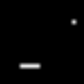

In [10]:
# evluation
env = CatchEnv()
state = env.reset_random()
state = transforms(state)
video = []

while True:
    q_values = dqn(state.to(device))
    action = q_values.argmax().item()
    next_state, reward, done = env.step(action)
    next_state = transforms(next_state)
    state = next_state
    video.append(next_state.squeeze(0))
    if done:
        break

frames = []
video = torch.stack(video)
# shape (k iterations, 4 frames, 84, 84)
# put side to side resulting in (4 * k, 84, 84) without changing the order
video = video.permute(1, 0, 2, 3).reshape(4 * len(video), 84, 84)

# video is of shape (time, 84, 84)
# make a gif and display it
import imageio
from IPython.display import Image

imageio.mimsave("dqn_conv.gif", 255 * video.cpu().numpy())
Image(filename="dqn_conv.gif", format='png')